# MNIST VAE demo

This notebook demonstrates the basic convolutional variational autoencoder on a dataset of rotating MNIST images.

In [1]:
import os
import csv
import sys
import torch
import pickle
import gpytorch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch import optim
from torch.utils import data
from torchvision import transforms
from torch.nn import functional as F

In [2]:
# we need to manually add the project directory to the path when using Jupyter notebooks
#sys.path.append("/home/santeri/repos/HIT_VAE")
sys.path.append("/u/14/mentus1/unix/repos/HIT_VAE")

In [3]:
from hit_vae.models import mnist_conv_vae
from hit_vae.models import losses
from hit_vae.utils import data_loading
from hit_vae.utils import plotting

In [4]:
# use the ggplot2 style in plots
plt.style.use('ggplot')

In [5]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using device: {}'.format(device))

using device: cuda


## Loading the data

In [6]:
data_base_path = '../../data/mnist_gen'
# csv which contains the IDs and labels for the training data
label_path = os.path.join(data_base_path, 'labels.csv')
label_df = pd.read_csv(label_path, index_col=0)
labels = label_df.to_dict(orient='index')
# we also store all the labels in a separate list
list_IDs = list(labels.keys())

In [7]:
# for expariments use 30% of the samples for testing and validation and 70% for training
test_ratio = 0.3

# transformations applied to samples
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    ])

# we use the Dataset class defined in utils to store the data
training_set = data_loading.Dataset(data_base_path, list_IDs, labels, transform=transform)

n_train = len(training_set)
indices = list(labels.keys())
np.random.shuffle(indices) # we randomize the order of the samples
test_split = int(np.floor(test_ratio * n_train))
test_IDs, training_IDs = indices[:test_split], indices[test_split:]

In [8]:
# change the number of workers based on your CPU
loader_params = {'batch_size': 32, 'num_workers': 4}

training_sampler = data.SubsetRandomSampler(training_IDs)
test_sampler = data.SubsetRandomSampler(test_IDs)

# torch data loaders with parallelization for efficiency
training_loader = data.DataLoader(training_set, **loader_params, sampler=training_sampler)
test_loader = data.DataLoader(training_set, **loader_params, sampler=test_sampler)

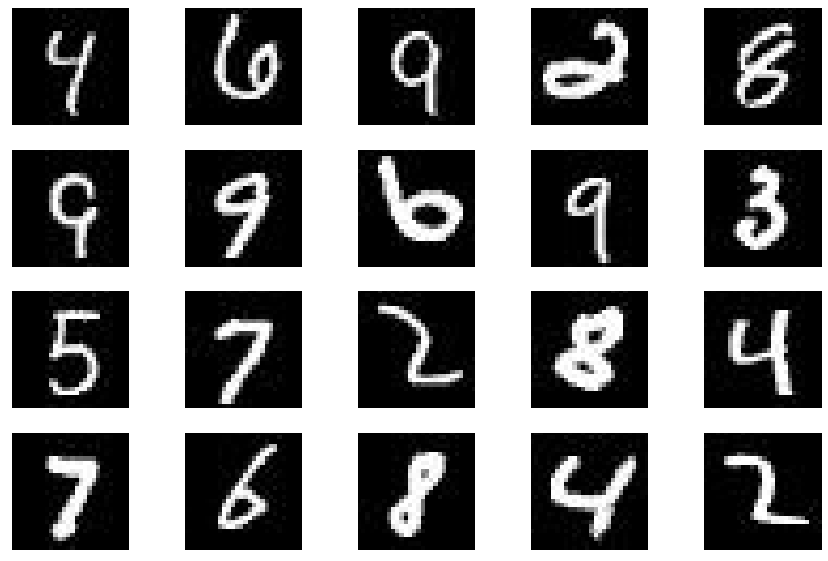

In [9]:
# visualize a set of samples as a check
images, labels = iter(training_loader).next()
plotting.visualize_samples(iter(training_loader))

## Setting up the model

In [10]:
# initialize the model defined in the models module
ldim = 2
vae_model = mnist_conv_vae.DigitVae(ldim=ldim)
vae_model.to(device)

DigitVae(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc21): Linear(in_features=32, out_features=2, bias=True)
  (fc22): Linear(in_features=32, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=784, bias=True)
  (deconv1): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [11]:
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

In [12]:
def train(epoch):
    vae_model.train()
    train_loss = 0
    train_BCE = 0
    train_KLD = 0
    for batch_idx, (data, _) in enumerate(training_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae_model(data)
        BCE, KLD = losses.vae_loss(recon_batch, data, mu, logvar)
        loss = BCE + KLD
        loss.backward()
        train_BCE += BCE.item()
        train_KLD += KLD.item()
        train_loss += loss.item()
        optimizer.step()
    
    if epoch % 10 == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(training_loader.dataset)))
    
    return train_BCE, train_KLD, train_loss

In [13]:
def test(epoch, show_comparison=False):
    Z = torch.tensor([])
    Z = Z.to(device)
    
    # change this based on the labelling of the samples
    #l = {'subject': [], 'digit': [], 'angle': [], 'sick': [], 'timestamp': []}
    l = {'digit': []}
    
    vae_model.eval()
    test_loss = 0
    test_BCE = 0
    test_KLD = 0

    
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = vae_model(data)
            #print('this is mu: {}'.format(mu))
            Z = torch.cat((Z, mu), dim=0)
            #print(len(Z))
            [l[key].extend(labels[key].numpy()) for key in l.keys()]
            
            BCE, KLD = losses.vae_loss(recon_batch, data, mu, logvar)
            test_KLD += KLD.item()
            test_BCE += BCE.item()
            test_loss += BCE.item() + KLD.item()
            if show_comparison and i == 0 and epoch % 10 == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch[:n]])
                img = comparison.cpu()
                #print(comparison)
                fig = plt.figure(figsize=(15, 10))
                for i in np.arange(16):
                    ax = fig.add_subplot(4, 16/4, i+1, xticks=[], yticks=[])
                    plt.imshow(img[i].view(-1, 28), cmap='gray')
                
                plt.show()
                #save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow=n)
    
    test_BCE /= len(test_loader.dataset)
    test_KLD /= len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    
    #print(data.shape)
    #print(labels.shape)
    #print(Z.shape)
    
    savepath = '../../results/MNIST_VAE/latent_epoch_{}.png'.format(epoch)
    if epoch % 10 == 0:
        print('====> Test set BCE: {:.4f}, KLD: {:.4f}, loss: {:.4f}'.format(test_BCE, test_KLD, test_loss))
        if ldim == 1:
            plotting.visualize_latent_1D(Z.cpu().numpy(), l, 'timestamp', 'subject', colormap='Set1')
        if ldim == 2:
            #vae.visualize_latent(Z.cpu().numpy(), l, 'timestamp', savepath, colormap='viridis')
            plotting.visualize_latent(Z.cpu().numpy(), l, 'digit', savepath, colormap='viridis')
            
            pickle.dump(Z, open( "../../data/Z.p", "wb" ) )
            pickle.dump(l['digit'], open( "../../data/labels.p", "wb" ) )
    
    return test_BCE, test_KLD, test_loss

In [14]:
#%%time

epochs = 150

train_BCEs = []
train_KLDs = []
train_losses = []

test_BCEs = []
test_KLDs = []
test_losses = []

for epoch in range(1, epochs + 1):
    train_BCE, train_KLD, train_loss = train(epoch)
    test_BCE, test_KLD, test_loss = test(epoch)
    
    train_BCEs.append(train_BCE)
    train_KLDs.append(train_KLD)
    train_losses.append(train_loss)
    
    test_BCEs.append(test_BCE)
    test_KLDs.append(test_KLD)
    test_losses.append(test_loss)
    
    with torch.no_grad():
        sample = torch.randn(64, ldim).to(device)
        sample = vae_model.decode(sample).cpu()
        #save_image(sample.view(64, 1, 28, 28),
        #           'results/sample_' + str(epoch) + '.png')

====> Epoch: 10 Average loss: 144.2609
====> Test set BCE: 60.6197, KLD: 0.5578, loss: 61.1775
====> Epoch: 20 Average loss: 139.7351
====> Test set BCE: 59.2483, KLD: 0.5541, loss: 59.8023
====> Epoch: 30 Average loss: 134.6446
====> Test set BCE: 56.3079, KLD: 0.9458, loss: 57.2537
====> Epoch: 40 Average loss: 130.0000
====> Test set BCE: 54.4840, KLD: 1.0887, loss: 55.5728
====> Epoch: 50 Average loss: 126.3995
====> Test set BCE: 52.6251, KLD: 1.2414, loss: 53.8666
====> Epoch: 60 Average loss: 123.7200
====> Test set BCE: 51.6229, KLD: 1.3726, loss: 52.9956
====> Epoch: 70 Average loss: 121.5139
====> Test set BCE: 51.3257, KLD: 1.3555, loss: 52.6812
====> Epoch: 80 Average loss: 120.0623
====> Test set BCE: 50.9150, KLD: 1.4450, loss: 52.3600
====> Epoch: 90 Average loss: 118.8640
====> Test set BCE: 50.7782, KLD: 1.5275, loss: 52.3057
====> Epoch: 100 Average loss: 117.4864
====> Test set BCE: 50.1172, KLD: 1.5664, loss: 51.6836
====> Epoch: 110 Average loss: 116.4502
====> Tes

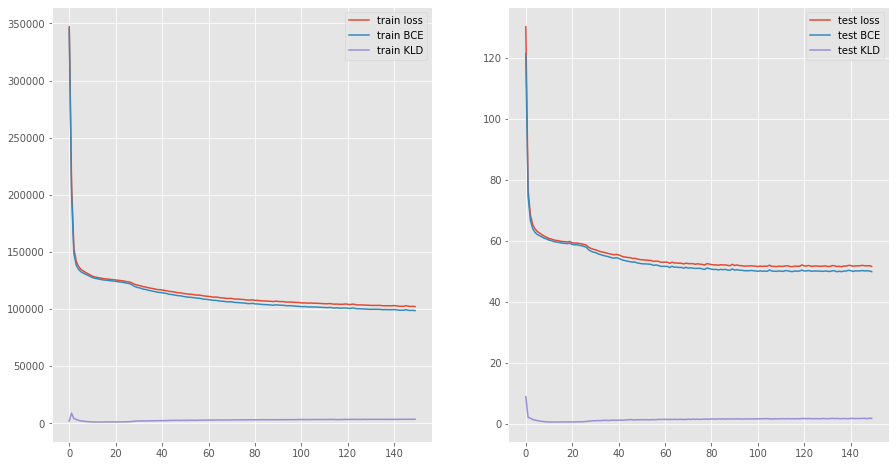

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 8))
ax1.plot(train_losses, label='train loss')
ax1.plot(train_BCEs, label='train BCE')
ax1.plot(train_KLDs, label='train KLD')
ax1.legend()

ax2.plot(test_losses, label='test loss')
ax2.plot(test_BCEs, label='test BCE')
ax2.plot(test_KLDs, label='test KLD')
ax2.legend()

plt.show()

In [16]:
ckpt_name = 'basic_conv_vae_noise_MNIST.pt'
savepath = '../../trained_models'
torch.save(vae_model.state_dict(), os.path.join(savepath, ckpt_name))